![Fixel Algorithms](https://fixelalgorithms.co/images/CCExt.png)

# <center> Introduction to Machine Learning </center>
## <center> Lecture 18 - PyTorch</center>
### <center> Regression Exercise - Solution</center>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FixelAlgorithmsTeam/FixelCourses/blob/master/IntroductionToMachineLearning/18_PyTorch/MainPyTorch1%20-%20Solution.ipynb)

In [1]:
#-- Wide screen:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
#-- Auto reload:
%load_ext autoreload
%autoreload 2

In [1]:
#-- Imports:
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rc('font', **{'size' : 16})

#-- torch:
import torch

#-- Fix seed (for presentation sake)
torch.manual_seed(0)
np.random.seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark     = False

## Auxiliary functions

For Colab users:

In [2]:
!wget https://raw.githubusercontent.com/FixelAlgorithmsTeam/FixelCourses/master/IntroductionToMachineLearning/18_PyTorch/PyTorchExampleAux.py

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [3]:
#-- Record figures during training:
from PyTorchExampleAux import Plot, Recorder

In [4]:
from sklearn.metrics import r2_score

def R2Score(vHatY, vY):
    return r2_score(vY.detach().cpu(), vHatY.detach().cpu())

### Training loop:

In [5]:
def TrainLoop(oModel, oTrainDL, LossFunc, oOptim):

    epochLoss = 0
    epochR2   = 0
    count     = 0                                #-- number of samples
    device    = next(oModel.parameters()).device #-- CPU\GPU
    oModel.train(True)
        
    #-- Iterate over the mini-batches:
    for ii, (mX, vY) in enumerate(oTrainDL):
        #-- Move to device (CPU\GPU):
        mX = mX.to(device)
        vY = vY.to(device)
        
        #-- Set gradients to zeros:
        oOptim.zero_grad()
        
        #-- Forward:
        vHatY = oModel(mX).squeeze()
        loss  = LossFunc(vHatY, vY)

        #-- Backward:
        loss.backward()

        #-- Parameters update:
        oOptim.step()
        
        print(f'Iteration: {ii:3d}: loss = {loss:.6f}\r', end='')
        #-- Accumulate loss:
        Nb         = mX.shape[0]
        epochLoss += Nb * loss.item()
        epochR2   += Nb * R2Score(vHatY, vY)
        count     += Nb

    epochLoss /= count
    epochR2   /= count
   
    return epochLoss, epochR2

In [6]:
def ValidationLoop(oModel, oValDL, LossFunc):

    if oValDL is None:
        return 0, 0
    
    epochLoss = 0
    epochR2   = 0
    count     = 0                                #-- number of samples
    device    = next(oModel.parameters()).device #-- CPU\GPU
    
    #-- Iterate over the mini-batches:
    oModel.train(False)
    with torch.no_grad():
        for ii, (mX, vY) in enumerate(oValDL):
            #-- Move to device (CPU\GPU):
            mX = mX.to(device)
            vY = vY.to(device)
            
            #-- Forward:
            vHatY = oModel(mX).squeeze()
            loss  = LossFunc(vHatY, vY)

            Nb         = mX.shape[0]
            epochLoss += Nb * loss.item()
            epochR2   += Nb * R2Score(vHatY, vY)
            count     += Nb

    epochLoss /= count
    epochR2   /= count

    return epochLoss, epochR2

In [7]:
import time

def TrainModel(oModel, oTrainDL, oValDL, LossFunc, numEpochs, oOptim):

    oRecorder = Recorder([
        Plot('Loss',     'train', 'epoch', 'b'),
        Plot('Loss',     'val',   'epoch', 'r'),
        Plot('R2 score', 'train', 'epoch', 'b'),
        Plot('R2 score', 'val',   'epoch', 'r'),
    ])

    bestR2 = 0
    for epoch in range(numEpochs):
        
        startTime          = time.time()
        trainLoss, trainR2 = TrainLoop     (oModel, oTrainDL, LossFunc, oOptim) #-- train
        valLoss,   valR2   = ValidationLoop(oModel, oValDL,   LossFunc)         #-- validation
        
        #-- Display:
        oRecorder.Append('Loss',     'train', trainLoss),
        oRecorder.Append('Loss',     'val',   valLoss),
        oRecorder.Append('R2 score', 'train', trainR2),
        oRecorder.Append('R2 score', 'val',   valR2),
        oRecorder.Draw()

        endTime = time.time()
        print('Epoch '              f'{epoch:3d}:',                  end='')
        print(' | Train loss: '     f'{trainLoss:.5f}',              end='')
        print(' | Val loss: '       f'{valLoss:.5f}',                end='')
        print(' | Train R2 score: ' f'{trainR2:2.4f}',               end='')
        print(' | Val R2 score: '   f'{valR2:2.4f}',                 end='')
        print(' | epoch time: '     f'{(endTime-startTime):3.3f} |', end='')
        
        #-- Save best model:
        if valR2 > bestR2:
            bestR2 = valR2
            try:
                torch.save(oModel.state_dict(), 'BestModelParameters.pt')
            except:
                pass
            print(' <-- Checkpoint!')
        else:
            print()

    oModel.load_state_dict(torch.load('BestModelParameters.pt'))

### Download dataset:

In [8]:
from sklearn.datasets import fetch_california_housing

mX, vY  = fetch_california_housing(return_X_y=True)
mX     -= np.mean(mX, axis=0)
mX     /= np.std(mX, axis=0)

mX.shape, vY.shape

((20640, 8), (20640,))

In [9]:
from sklearn.model_selection import train_test_split

Ntrain  = 15000
Ntest   = 5640
vIdx    = np.random.choice(Ntrain + Ntest, Ntrain + Ntest)
mX      = mX[vIdx,:]
vY      = vY[vIdx]

mTrainX, mTestX, vTrainY, vTestY = train_test_split(mX, vY, train_size=Ntrain, test_size=Ntest)

(mTrainX.shape, 
vTrainY.shape, 
mTestX.shape,  
vTestY.shape)

((15000, 8), (15000,), (5640, 8), (5640,))

In [11]:
mTrainX

array([[-0.50862373,  1.85618152, -0.41417572, ..., -0.11460867,
         1.04318455, -1.34280914],
       [ 0.16319242, -1.79889009, -0.01282862, ..., -0.04769135,
        -1.15261046,  1.13287921],
       [ 0.09550022,  0.50539419,  0.13101192, ...,  0.11325146,
        -0.74997001,  0.81343555],
       ...,
       [ 0.15087518, -0.76593507,  0.29652241, ..., -0.01629832,
        -0.46905807,  0.69364418],
       [ 1.52151067, -0.05081236,  0.75045658, ..., -0.00405205,
        -0.67037829,  0.3592266 ],
       [-0.47709369,  0.66431034, -0.04554085, ...,  0.04772588,
        -0.81551613,  0.65870503]])

In [12]:
torch.tensor(mTrainX)

tensor([[-0.5086,  1.8562, -0.4142,  ..., -0.1146,  1.0432, -1.3428],
        [ 0.1632, -1.7989, -0.0128,  ..., -0.0477, -1.1526,  1.1329],
        [ 0.0955,  0.5054,  0.1310,  ...,  0.1133, -0.7500,  0.8134],
        ...,
        [ 0.1509, -0.7659,  0.2965,  ..., -0.0163, -0.4691,  0.6936],
        [ 1.5215, -0.0508,  0.7505,  ..., -0.0041, -0.6704,  0.3592],
        [-0.4771,  0.6643, -0.0455,  ...,  0.0477, -0.8155,  0.6587]],
       dtype=torch.float64)

In [13]:
torch.tensor(mTrainX, dtype=torch.float32)

tensor([[-0.5086,  1.8562, -0.4142,  ..., -0.1146,  1.0432, -1.3428],
        [ 0.1632, -1.7989, -0.0128,  ..., -0.0477, -1.1526,  1.1329],
        [ 0.0955,  0.5054,  0.1310,  ...,  0.1133, -0.7500,  0.8134],
        ...,
        [ 0.1509, -0.7659,  0.2965,  ..., -0.0163, -0.4691,  0.6936],
        [ 1.5215, -0.0508,  0.7505,  ..., -0.0041, -0.6704,  0.3592],
        [-0.4771,  0.6643, -0.0455,  ...,  0.0477, -0.8155,  0.6587]])

In [19]:
from torch.utils.data import TensorDataset

oTrainSet = TensorDataset(torch.tensor(mTrainX, dtype=torch.float32), torch.tensor(vTrainY, dtype=torch.float32))
oTestSet  = TensorDataset(torch.tensor(mTestX,  dtype=torch.float32), torch.tensor(vTestY,  dtype=torch.float32))

### Create data loaders:

In [20]:
batchSize = 128
oTrainDL  = torch.utils.data.DataLoader(oTrainSet, shuffle=True,  batch_size=batchSize,   num_workers=2)
oTestDL   = torch.utils.data.DataLoader(oTestSet,  shuffle=False, batch_size=2*batchSize, num_workers=2)

### Define the model:

In [15]:
import torch.nn            as nn
import torch.nn.functional as F
import torch.optim         as optim
import torchsummary

#--------------------------------------------------------------------------------#
#--------------------------------------------------------------------------------#
#-- Just for the summary (identity):
class InputLayer(nn.Sequential):
    pass    

In [16]:
#-- Model:
def GetModel():
    p      = 0.10
    oModel = nn.Sequential(
        InputLayer(), #-- does nothing
        nn.Linear(8,   150), nn.ReLU(), nn.Dropout(p),
        nn.Linear(150, 150), nn.ReLU(), nn.Dropout(p),
        nn.Linear(150, 150), nn.ReLU(), nn.Dropout(p),
        nn.Linear(150, 150), nn.ReLU(), nn.Dropout(p),
        nn.Linear(150, 150), nn.ReLU(), nn.Dropout(p),
        nn.Linear(150, 1),
    )
    return oModel

#--------------------------------------------------------------------------------#
#--------------------------------------------------------------------------------#
torchsummary.summary(GetModel(), (8,), device='cpu'); print()

Layer (type:depth-idx)                   Output Shape              Param #
├─InputLayer: 1-1                        [-1, 8]                   --
├─Linear: 1-2                            [-1, 150]                 1,350
├─ReLU: 1-3                              [-1, 150]                 --
├─Dropout: 1-4                           [-1, 150]                 --
├─Linear: 1-5                            [-1, 150]                 22,650
├─ReLU: 1-6                              [-1, 150]                 --
├─Dropout: 1-7                           [-1, 150]                 --
├─Linear: 1-8                            [-1, 150]                 22,650
├─ReLU: 1-9                              [-1, 150]                 --
├─Dropout: 1-10                          [-1, 150]                 --
├─Linear: 1-11                           [-1, 150]                 22,650
├─ReLU: 1-12                             [-1, 150]                 --
├─Dropout: 1-13                          [-1, 150]                 --


In [21]:
oModel = GetModel()
oModel

Sequential(
  (0): InputLayer()
  (1): Linear(in_features=8, out_features=150, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.1, inplace=False)
  (4): Linear(in_features=150, out_features=150, bias=True)
  (5): ReLU()
  (6): Dropout(p=0.1, inplace=False)
  (7): Linear(in_features=150, out_features=150, bias=True)
  (8): ReLU()
  (9): Dropout(p=0.1, inplace=False)
  (10): Linear(in_features=150, out_features=150, bias=True)
  (11): ReLU()
  (12): Dropout(p=0.1, inplace=False)
  (13): Linear(in_features=150, out_features=150, bias=True)
  (14): ReLU()
  (15): Dropout(p=0.1, inplace=False)
  (16): Linear(in_features=150, out_features=1, bias=True)
)

### Check whether GPU is available:

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
device

device(type='cuda', index=0)

### Loss function:

In [16]:
LossFunc = nn.MSELoss()

### Train the model (constant learning rate):

<IPython.core.display.Javascript object>


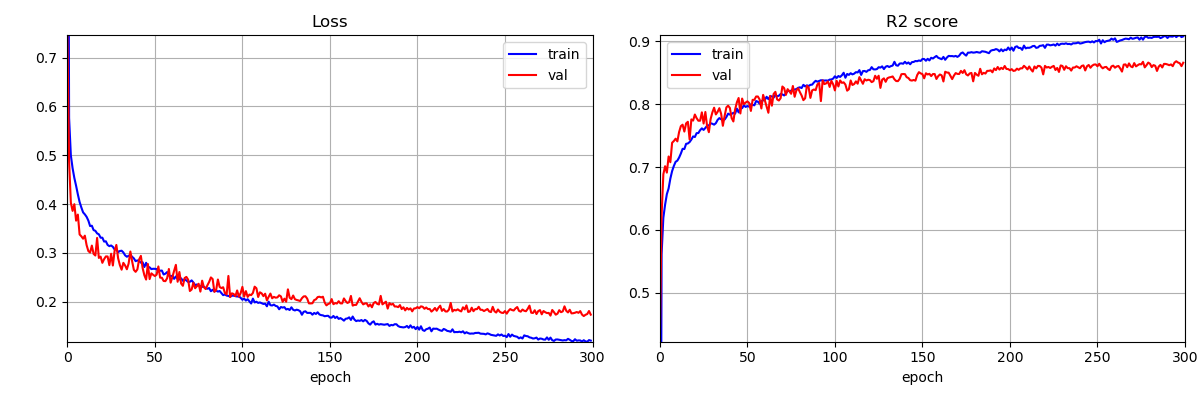

Epoch   0: | Train loss: 1.72517 | Val loss: 0.74548 | Train R2 score: -0.3056 | Val R2 score: 0.4221 | epoch time: 3.986 | <-- Checkpoint!
Epoch   1: | Train loss: 0.57621 | Val loss: 0.48696 | Train R2 score: 0.5616 | Val R2 score: 0.6238 | epoch time: 3.646 | <-- Checkpoint!
Epoch   2: | Train loss: 0.49974 | Val loss: 0.40264 | Train R2 score: 0.6194 | Val R2 score: 0.6887 | epoch time: 3.583 | <-- Checkpoint!
Epoch   3: | Train loss: 0.47329 | Val loss: 0.38596 | Train R2 score: 0.6403 | Val R2 score: 0.7015 | epoch time: 3.576 | <-- Checkpoint!
Epoch   4: | Train loss: 0.45334 | Val loss: 0.39972 | Train R2 score: 0.6570 | Val R2 score: 0.6913 | epoch time: 3.599 |
Epoch   5: | Train loss: 0.43737 | Val loss: 0.36593 | Train R2 score: 0.6660 | Val R2 score: 0.7170 | epoch time: 3.927 | <-- Checkpoint!
Epoch   6: | Train loss: 0.41983 | Val loss: 0.37844 | Train R2 score: 0.6818 | Val R2 score: 0.7078 | epoch time: 3.497 |
Epoch   7: | Train loss: 0.40420 | Val loss: 0.33771 | Tra

Epoch  64: | Train loss: 0.24548 | Val loss: 0.26076 | Train R2 score: 0.8128 | Val R2 score: 0.7979 | epoch time: 3.162 |
Epoch  65: | Train loss: 0.24786 | Val loss: 0.23722 | Train R2 score: 0.8105 | Val R2 score: 0.8165 | epoch time: 3.263 | <-- Checkpoint!
Epoch  66: | Train loss: 0.24270 | Val loss: 0.23255 | Train R2 score: 0.8151 | Val R2 score: 0.8199 | epoch time: 3.332 | <-- Checkpoint!
Epoch  67: | Train loss: 0.24588 | Val loss: 0.24845 | Train R2 score: 0.8127 | Val R2 score: 0.8078 | epoch time: 3.251 |
Epoch  68: | Train loss: 0.24351 | Val loss: 0.25078 | Train R2 score: 0.8137 | Val R2 score: 0.8061 | epoch time: 3.248 |
Epoch  69: | Train loss: 0.24045 | Val loss: 0.24516 | Train R2 score: 0.8164 | Val R2 score: 0.8099 | epoch time: 3.296 |
Epoch  70: | Train loss: 0.24087 | Val loss: 0.22191 | Train R2 score: 0.8158 | Val R2 score: 0.8283 | epoch time: 3.362 | <-- Checkpoint!
Epoch  71: | Train loss: 0.24365 | Val loss: 0.22499 | Train R2 score: 0.8141 | Val R2 scor

Epoch 195: | Train loss: 0.14646 | Val loss: 0.18399 | Train R2 score: 0.8876 | Val R2 score: 0.8581 | epoch time: 3.337 |
Epoch 196: | Train loss: 0.15156 | Val loss: 0.18638 | Train R2 score: 0.8844 | Val R2 score: 0.8561 | epoch time: 3.191 |
Epoch 197: | Train loss: 0.14674 | Val loss: 0.18028 | Train R2 score: 0.8871 | Val R2 score: 0.8610 | epoch time: 3.185 | <-- Checkpoint!
Epoch 198: | Train loss: 0.14862 | Val loss: 0.18612 | Train R2 score: 0.8862 | Val R2 score: 0.8563 | epoch time: 3.237 |
Epoch 199: | Train loss: 0.14377 | Val loss: 0.18652 | Train R2 score: 0.8904 | Val R2 score: 0.8561 | epoch time: 3.299 |
Epoch 200: | Train loss: 0.14835 | Val loss: 0.18898 | Train R2 score: 0.8866 | Val R2 score: 0.8542 | epoch time: 3.332 |
Epoch 201: | Train loss: 0.14277 | Val loss: 0.18663 | Train R2 score: 0.8904 | Val R2 score: 0.8560 | epoch time: 3.328 |
Epoch 202: | Train loss: 0.14970 | Val loss: 0.19049 | Train R2 score: 0.8853 | Val R2 score: 0.8532 | epoch time: 3.317 |


Epoch 261: | Train loss: 0.13107 | Val loss: 0.18143 | Train R2 score: 0.8993 | Val R2 score: 0.8603 | epoch time: 3.356 |
Epoch 262: | Train loss: 0.12971 | Val loss: 0.18048 | Train R2 score: 0.9004 | Val R2 score: 0.8610 | epoch time: 3.384 |
Epoch 263: | Train loss: 0.12921 | Val loss: 0.18547 | Train R2 score: 0.9017 | Val R2 score: 0.8571 | epoch time: 3.384 |
Epoch 264: | Train loss: 0.12696 | Val loss: 0.19196 | Train R2 score: 0.9024 | Val R2 score: 0.8521 | epoch time: 3.394 |
Epoch 265: | Train loss: 0.12618 | Val loss: 0.17744 | Train R2 score: 0.9036 | Val R2 score: 0.8632 | epoch time: 3.286 |
Epoch 266: | Train loss: 0.12460 | Val loss: 0.17694 | Train R2 score: 0.9045 | Val R2 score: 0.8635 | epoch time: 3.126 |
Epoch 267: | Train loss: 0.12508 | Val loss: 0.18251 | Train R2 score: 0.9042 | Val R2 score: 0.8591 | epoch time: 3.172 |
Epoch 268: | Train loss: 0.12652 | Val loss: 0.17472 | Train R2 score: 0.9036 | Val R2 score: 0.8651 | epoch time: 3.082 | <-- Checkpoint!


In [17]:
%matplotlib notebook

oModel = GetModel().to(device)
oOptim = optim.AdamW(oModel.parameters(), lr=4e-4, betas=(0.9, 0.99), weight_decay=2e-5)
TrainModel(oModel, oTrainDL, oTestDL, LossFunc, 300, oOptim)

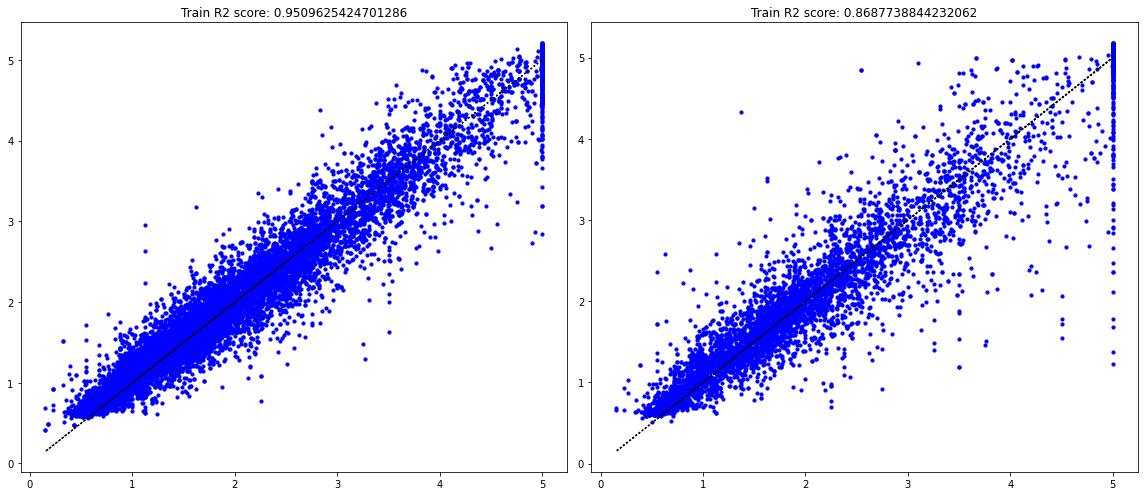

In [18]:
#%matplotlib inline

from sklearn.metrics import r2_score

#-- Apply model to data:
vHatTrainY = oModel(torch.tensor(mTrainX, dtype=torch.float32).cuda()).squeeze()
vHatTestY  = oModel(torch.tensor(mTestX,  dtype=torch.float32).cuda()).squeeze()

_, ax = plt.subplots(1, 2, figsize=(16,7))

ax[0].scatter(vTrainY, vHatTrainY, s=10, c='b', edgecolor=None)
ax[1].scatter(vTestY,  vHatTestY,  s=10, c='b', edgecolor=None)
ax[0].plot(vTrainY,    vTrainY, ':k')
ax[1].plot(vTestY,     vTestY, ':k')
ax[0].set_title('Train R2 score: ' + str(R2Score(vHatY, vY)(vTrainY, vHatTrainY)))
ax[1].set_title('Train R2 score: ' + str(R2Score(vHatY, vY)(vTestY,  vHatTestY)))
plt.tight_layout()
plt.show()